In [ ]:
# Import dependencies
import pandas as pd
import numpy as np
import os
from google.colab import drive
import multiprocessing
from pyspark.sql import SparkSession
import psutil
from datetime import datetime
from geopy.distance import geodesic
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib

In [ ]:
# Find the latest version of spark 3.x  from https://downloads.apache.org/spark/ and enter as the spark version
spark_version = 'spark-3.5.5'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"
os.environ["SPARK_LOCAL_IP"] = "127.0.0.1"

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,321 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,235 kB]
Get:13 https://r2u.stat.illinois.edu/u

In [ ]:
# Utilize Multiprocessing - prevents overloading system
print("Available CPU cores:", multiprocessing.cpu_count())

Available CPU cores: 2


In [ ]:
# Optimize Spark Memory Allocation Dynamically
total_memory = psutil.virtual_memory().total // (1024 ** 3)  # Get total RAM in GB
spark = SparkSession.builder \
    .appName("OptimizedApp") \
    .config("spark.driver.memory", f"{min(8, total_memory//2)}g") \
    .config("spark.executor.memory", f"{min(8, total_memory//2)}g") \
    .getOrCreate()
print("Spark Session initialized with optimized memory allocation.")

Spark Session initialized with optimized memory allocation.


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Define the folder path
project_folder = "/content/drive/My Drive/Project_4" # Update the path for the "Data" folder
data_folder = os.path.join(project_folder, "Data")

# Create the "Data" folder if it doesn't exist
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

# Define the final save path
save_path = data_folder

# Install Kaggle
!pip install kaggle

# Download the dataset
!kaggle datasets download -d priyamchoksi/credit-card-transactions-dataset

# Unzip the dataset into the "Data" folder
!unzip credit-card-transactions-dataset.zip -d "$save_path"

# Check if the file was saved successfully
if os.path.exists(save_path):
    print(f"✅ Dataset successfully saved in: {save_path}")
else:
    print("❌ Failed to save the dataset to Google Drive.")


Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/priyamchoksi/credit-card-transactions-dataset
License(s): apache-2.0
 90% 131M/145M [00:00<00:00, 173MB/s]
100% 145M/145M [00:00<00:00, 176MB/s]
Archive:  credit-card-transactions-dataset.zip
  inflating: /content/drive/My Drive/Project_4/Data/credit_card_transactions.csv  
✅ Dataset successfully saved in: /content/drive/My Drive/Project_4/Data


In [ ]:
# Example: Load a CSV file into a Spark DataFrame
spark_df = spark.read.csv("/content/drive/My Drive/Project_4/Data/credit_card_transactions.csv", header=True, inferSchema=True) # Update the path

# Convert to Pandas DataFrame
df = spark_df.toPandas()

In [ ]:
# Display the column names and a preview of the data
print("Columns in the dataset:")
print(df.columns)
print("\nPreview of data:")
print(df.head())

Columns in the dataset:
Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'merch_zipcode'],
      dtype='object')

Preview of data:
   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2                fraud_Lind-Buckridge  entertainment  220.11     Edward   


In [ ]:
# Convert columns to datetime
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['dob'] = pd.to_datetime(df['dob'])

# Extract year of birth to calculate age later
df['year_of_birth'] = df['dob'].dt.year


In [ ]:
# Calculate customer's age
current_year = pd.to_datetime('today').year
df['age'] = current_year - df['year_of_birth']

# Extract day of week and hour from transaction time
df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
df['hour_of_day'] = df['trans_date_trans_time'].dt.hour


In [ ]:
# Display the column names and a preview of the data
print("Columns in the dataset:")
print(df.columns)
print("\nPreview of data:")
print(df.head())

Columns in the dataset:
Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'merch_zipcode', 'year_of_birth',
       'age', 'day_of_week', 'hour_of_day'],
      dtype='object')

Preview of data:
   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2             

In [ ]:
# Check for missing values
print(df.isnull().sum())

# Fill numeric missing values with the median or mean
df.fillna({'merch_zipcode': df['merch_zipcode'].median()}, inplace=True)

# Drop rows where essential information is missing (if any)
df.dropna(subset=['category', 'state', 'is_fraud'], inplace=True)


Unnamed: 0                    0
trans_date_trans_time         0
cc_num                        0
merchant                      0
category                      0
amt                           0
first                         0
last                          0
gender                        0
street                        0
city                          0
state                         0
zip                           0
lat                           0
long                          0
city_pop                      0
job                           0
dob                           0
trans_num                     0
unix_time                     0
merch_lat                     0
merch_long                    0
is_fraud                      0
merch_zipcode            195973
year_of_birth                 0
age                           0
day_of_week                   0
hour_of_day                   0
dtype: int64


### **Analysis of Dropped Columns**
The following columns have been identified as non-beneficial for machine learning and are removed from the dataset:

1. **Unnamed: 0:**
This is often an index column that results from saving and loading data in formats like CSV.
It does not provide any predictive value and is purely a placeholder.  

2. **Transaction-Related Identifiers**    
  **trans_date_trans_time**: This column represents the transaction timestamp. While time-based trends could be useful in time-series models, it is not directly useful for general machine learning classification or regression tasks unless feature-engineered.  
  **trans_num**: A unique transaction identifier that does not contribute to predictive analysis. Keeping it could lead to data leakage, as the ID itself may be unique to the transaction rather than a meaningful feature.

3. **Personally Identifiable Information (PII)**  
  **cc_num**: Credit card number is a highly sensitive PII feature that should never be included in modeling due to ethical and security concerns. It does not provide predictive value.  
  **first, last**: Names of individuals do not influence transaction behaviors and should be removed to avoid privacy concerns.  
  **street, zip, city, state**: These are personally identifiable location details that do not provide meaningful insights unless aggregated into broader geographic features.  
  **dob, year_of_birth**: Direct date of birth is an unnecessary PII element. If age is required, it should be calculated before dropping this column.  
  **job**: While employment type could be useful in some contexts, it may introduce bias, and if not properly structured, it may not be informative.

4. **Geolocation Data**  
  **lat, long**: Latitude and longitude provide detailed geographic positioning but are often too granular for machine learning unless processed into regional features.  
  **merch_lat, merch_long**: Merchant location details may not be useful unless distance-based features are extracted. Raw latitude/longitude values do not contribute meaningfully in their current state.  
  **merch_zipcode**: Similar to city and state, this level of detail is often unnecessary and can introduce sparsity or overfitting.

5. **Unix Timestamp**  
  **unix_time**: This timestamp provides similar information to trans_date_trans_time. If temporal analysis is needed, converting it into cyclical features (such as time of day or day of the week) is preferable.

6. **Merchant Name**
  **merchant**: The name of the merchant is categorical but not necessarily useful unless there is a strong relationship between merchants and fraudulent transactions. It may introduce unnecessary complexity.

In [ ]:
# Drop the non-beneficial ID columns
df = df.drop([
  'Unnamed: 0',
  'trans_date_trans_time',
  'cc_num',
  'first',
  'last',
  'street',
  'dob',
  'year_of_birth',
  'trans_num',
  'unix_time',
  'merch_zipcode',
  'merchant',
  'merch_lat',
  'merch_long',
  'lat',
  'long',
  'zip',
  'city',
  'job',
  'state'
  ], axis=1, errors='ignore')

In [ ]:
# Display the column names and a preview of the data
print("Columns in the dataset:")
print(df.columns)
print("\nPreview of data:")
print(df.head())

Columns in the dataset:
Index(['category', 'amt', 'gender', 'city_pop', 'is_fraud', 'age',
       'day_of_week', 'hour_of_day'],
      dtype='object')

Preview of data:
        category     amt gender  city_pop  is_fraud  age  day_of_week  \
0       misc_net    4.97      F      3495         0   37            1   
1    grocery_pos  107.23      F       149         0   47            1   
2  entertainment  220.11      M      4154         0   63            1   
3  gas_transport   45.00      M      1939         0   58            1   
4       misc_pos   41.96      M        99         0   39            1   

   hour_of_day  
0            0  
1            0  
2            0  
3            0  
4            0  


In [ ]:
# One-hot encode categorical variables (one at a time to save RAM)
categorical_columns = ['category']

for col in categorical_columns:
    dummies = pd.get_dummies(df[col], prefix=col, dtype=int)
    df = pd.concat([df, dummies], axis=1)
    df.drop(col, axis=1, inplace=True)

print(df)

            amt gender  city_pop  is_fraud  age  day_of_week  hour_of_day  \
0          4.97      F      3495         0   37            1            0   
1        107.23      F       149         0   47            1            0   
2        220.11      M      4154         0   63            1            0   
3         45.00      M      1939         0   58            1            0   
4         41.96      M        99         0   39            1            0   
...         ...    ...       ...       ...  ...          ...          ...   
1296670   15.56      M       258         0   64            6           12   
1296671   51.70      M       100         0   46            6           12   
1296672  105.93      M       899         0   58            6           12   
1296673   74.90      M      1126         0   45            6           12   
1296674    4.30      M       218         0   30            6           12   

         category_entertainment  category_food_dining  category_gas_transpo

In [ ]:
# One-hot encode categorical variables (one at a time to save RAM)
categorical_columns = ['gender']

for col in categorical_columns:
    dummies = pd.get_dummies(df[col], prefix=col, dtype=int)
    df = pd.concat([df, dummies], axis=1)
    df.drop(col, axis=1, inplace=True)

print(df)

            amt  city_pop  is_fraud  age  day_of_week  hour_of_day  \
0          4.97      3495         0   37            1            0   
1        107.23       149         0   47            1            0   
2        220.11      4154         0   63            1            0   
3         45.00      1939         0   58            1            0   
4         41.96        99         0   39            1            0   
...         ...       ...       ...  ...          ...          ...   
1296670   15.56       258         0   64            6           12   
1296671   51.70       100         0   46            6           12   
1296672  105.93       899         0   58            6           12   
1296673   74.90      1126         0   45            6           12   
1296674    4.30       218         0   30            6           12   

         category_entertainment  category_food_dining  category_gas_transport  \
0                             0                     0                       0 

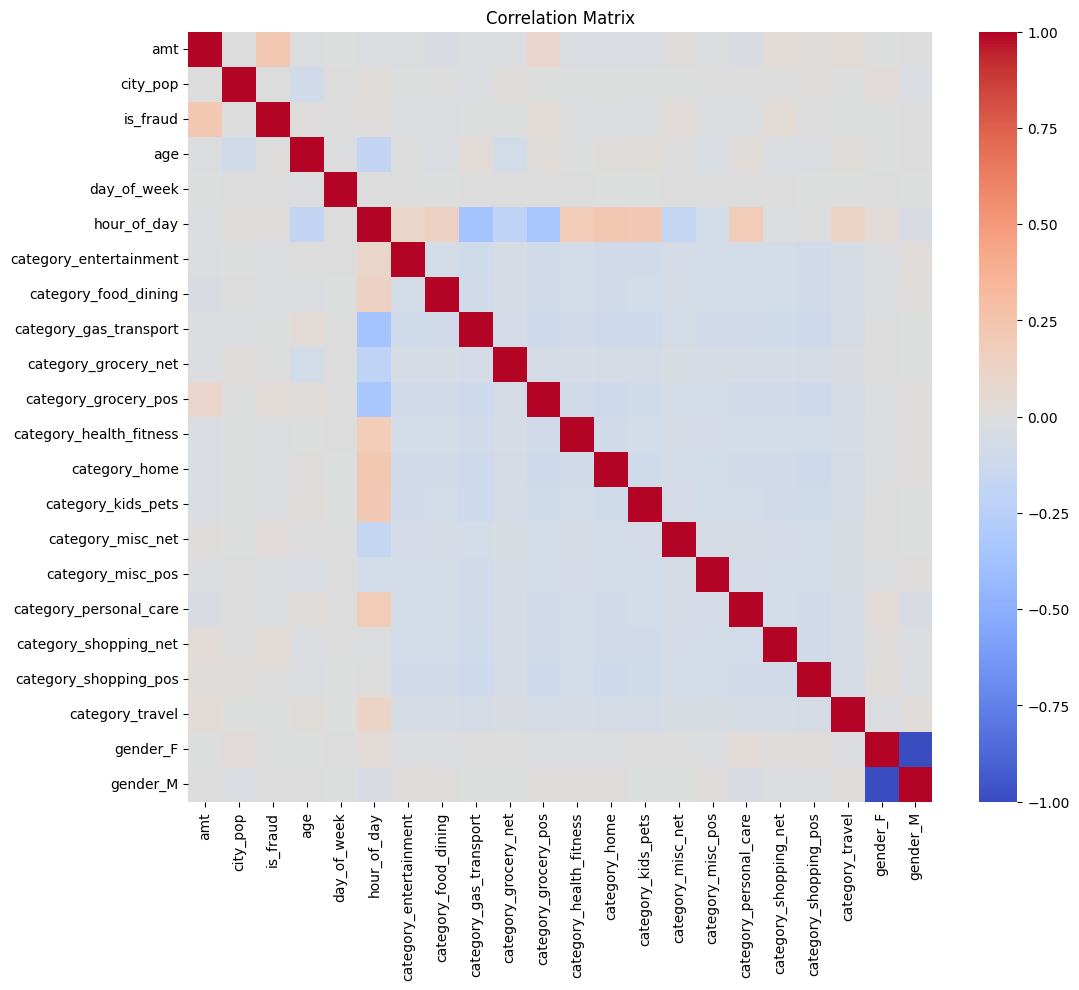

Correlation Matrix saved to: /content/drive/My Drive/Project_4/Visuals/correlation_matrix.png


In [ ]:
# Save on Google Drive "Project_4" in a folder named "Visuals"
visuals_folder = "/content/drive/My Drive/Project_4/Visuals"

# Create the folder if it doesn't exist
if not os.path.exists(visuals_folder):
    os.makedirs(visuals_folder)

# Define the save path for the correlation matrix
save_path = os.path.join(visuals_folder, "correlation_matrix.png")

# Create correlation matrix heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Matrix')

# Save the figure to Google Drive
plt.savefig(save_path, dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

print(f"✅ Correlation Matrix saved to: {save_path}")


In [ ]:
# Drop the non-beneficial gender column due to high correlation
df = df.drop(['gender_F', 'gender_M'], axis=1, errors='ignore')

In [ ]:
# Save a copy of the model dataframe
model_df = df.copy()

In [ ]:
# Save the model data CSV in the "Data" folder on Google Drive
model_df_path = "/content/drive/My Drive/Project_4/Data/model_data.csv"
model_df.to_csv(model_df_path, index=False)

print(f"✅ Model Data saved to {model_df_path}")

Model Data saved to /content/drive/My Drive/Project_4/Data/model_data.csv


In [ ]:
# Display the column names and a preview of the data
print("Columns in the dataset:")
print(model_df.columns)

Columns in the dataset:
Index(['amt', 'city_pop', 'is_fraud', 'age', 'day_of_week', 'hour_of_day',
       'category_entertainment', 'category_food_dining',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_pos', 'category_health_fitness', 'category_home',
       'category_kids_pets', 'category_misc_net', 'category_misc_pos',
       'category_personal_care', 'category_shopping_net',
       'category_shopping_pos', 'category_travel'],
      dtype='object')


In [ ]:
# Define features and label
X = model_df.drop(['is_fraud'], axis=1)
y = model_df['is_fraud']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Initialize the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Predict on the test data
predictions = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

Accuracy: 0.9985077216727399
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257815
           1       0.94      0.79      0.86      1520

    accuracy                           1.00    259335
   macro avg       0.97      0.90      0.93    259335
weighted avg       1.00      1.00      1.00    259335



In [ ]:
# Save on Google Drive "Project_4" in a folder named "Predictions"
project_folder = "/content/drive/My Drive/Project_4"
predictions_folder = os.path.join(project_folder, "Predictions")

# Create the "Predictions" folder if it doesn't exist
if not os.path.exists(predictions_folder):
    os.makedirs(predictions_folder)

# Compute accuracy and classification report
accuracy = accuracy_score(y_test, predictions)
report_dict = classification_report(y_test, predictions, output_dict=True)

# Convert classification report to DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Save accuracy separately
report_df.loc['accuracy'] = [accuracy, None, None, None]

# Define the save path inside the "Predictions" folder
report_file = os.path.join(predictions_folder, "original_0_model_predictions.csv")

# Save to CSV
report_df.to_csv(report_file, index=True)

# Print confirmation message
print(f"✅ Model predictions saved to: {report_file}")

✅ Model predictions saved to: /content/drive/My Drive/Project_4/Predictions/original_0_model_predictions.csv


In [ ]:
# Save on Google Drive "Project_4" in a folder named "Fraud_Detection_Models"
project_folder = "/content/drive/My Drive/Project_4"
models_folder = os.path.join(project_folder, "Fraud_Detection_Models")

# Create the "Fraud_Detection_Models" folder if it doesn't exist
if not os.path.exists(models_folder):
    os.makedirs(models_folder)

# Define the save path inside the "Fraud_Detection_Models" folder
model_path = os.path.join(models_folder, "original_model.joblib")

# Save the model using joblib
joblib.dump(model, model_path)

# Print confirmation message
print(f"✅ Model saved to: {model_path}")

✅ Model saved to: /content/drive/My Drive/Project_4/Fraud_Detection_Models/original_model.joblib
